In [ ]:
import os
import random
import shutil
import zipfile
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D



import os

import shutil

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
 98% 192M/195M [00:09<00:00, 23.3MB/s]
100% 195M/195M [00:09<00:00, 20.5MB/s]


In [ ]:
!unzip breast-ultrasound-images-dataset.zip -d dataset_dir

Archive:  breast-ultrasound-images-dataset.zip
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: dataset_dir/Dataset_BUSI_with_GT/benign/benign (10

In [ ]:
zip_path = '/content/breast-ultrasound-images-dataset.zip'
extract_to = '/content/breast-ultrasound-images-dataset'  # where to extract the files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [ ]:
# Check the contents of the extracted directory
dataset_dir = extract_to
print(os.listdir(dataset_dir))


['Dataset_BUSI_with_GT']


In [ ]:
dataset_dir = '/content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'  # Path to the directory containing benign, malignant, and normal folders

In [ ]:
# Set paths
malignant_dir = os.path.join(dataset_dir, 'malignant')
benign_dir = os.path.join(dataset_dir, 'benign')
normal_dir = os.path.join(dataset_dir, 'normal')

# Create directories for the split data
base_dir = "/content/split_dataset"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create subdirectories for each class
for category in ['malignant', 'benign', 'normal']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)


In [ ]:
##Function to upsample the minority class

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def augment_images(class_dir, target_count):
    current_count = len(os.listdir(class_dir))
    images_to_generate = target_count - current_count

    # If current_count is already greater than or equal to target_count, do nothing
    if images_to_generate <= 0:
        print(f"No augmentation needed for {class_dir}. Current count: {current_count}")
        return

    # Load all images from the class directory
    image_files = os.listdir(class_dir)
    generated_count = 0

    while generated_count < images_to_generate:
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path)
            x = img_to_array(img)  # Convert image to numpy array
            x = np.expand_dims(x, axis=0)  # Reshape to (1, width, height, channels)

            # Generate augmented images
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_dir, save_prefix='aug', save_format='jpeg'):
                generated_count += 1
                if generated_count >= images_to_generate:
                    break
        if generated_count >= images_to_generate:
            break

    print(f"Finished augmenting {class_dir}. Total images: {len(os.listdir(class_dir))}")

# Target number of images
target_count = 884

# Upsample Malignant and Normal classes to have the same number of images as Benign
augment_images(malignant_dir, target_count)
augment_images(normal_dir, target_count)

Finished augmenting /content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant. Total images: 1261
Finished augmenting /content/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal. Total images: 1115


Number of Malignant images: 1261
Number of Benign images: 891
Number of Normal images: 1115


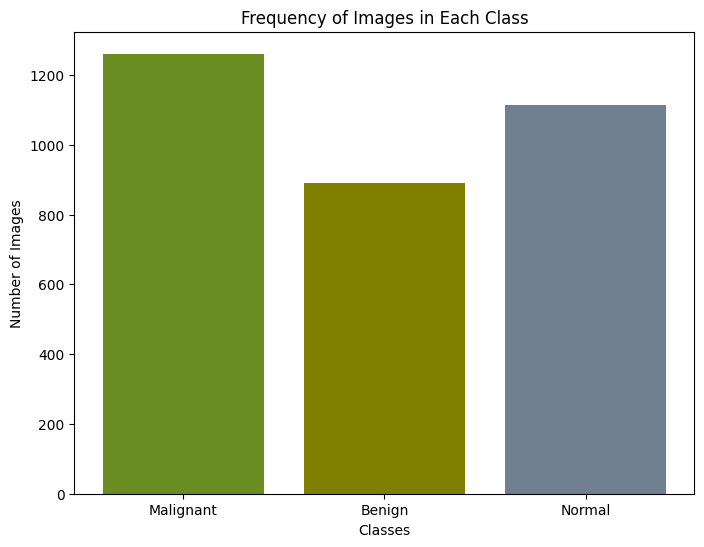

In [ ]:
# Recalculate the number of images in each class
num_malignant = len(os.listdir(malignant_dir))
num_benign = len(os.listdir(benign_dir))
num_normal = len(os.listdir(normal_dir))

print(f'Number of Malignant images: {num_malignant}')
print(f'Number of Benign images: {num_benign}')
print(f'Number of Normal images: {num_normal}')


# Prepare data for the bar chart
classes = ['Malignant', 'Benign', 'Normal']
frequencies = [num_malignant, num_benign, num_normal]

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(classes, frequencies, color=['olivedrab', 'olive', 'slategrey'])

# Add labels and title
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Frequency of Images in Each Class')
plt.show()

In [ ]:
# Function to split data
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
    data = []
    for item in os.listdir(SOURCE):
        item_path = os.path.join(SOURCE, item)
        if os.path.getsize(item_path) > 0:
            data.append(item)

    random.shuffle(data)
    train_size = int(SPLIT_SIZE * len(data))
    validation_size = int((len(data) - train_size) / 2)

    train_data = data[:train_size]
    validation_data = data[train_size:train_size + validation_size]
    test_data = data[train_size + validation_size:]

    for item in train_data:
        shutil.copy(os.path.join(SOURCE, item), os.path.join(TRAINING, item))

    for item in validation_data:
        shutil.copy(os.path.join(SOURCE, item), os.path.join(VALIDATION, item))

    for item in test_data:
        shutil.copy(os.path.join(SOURCE, item), os.path.join(TESTING, item))

# Define split size (e.g., 70% train, 15% validation, 15% test)
split_size = 0.7

# Split the data
split_data(malignant_dir, os.path.join(train_dir, 'malignant'), os.path.join(validation_dir, 'malignant'), os.path.join(test_dir, 'malignant'), split_size)
split_data(benign_dir, os.path.join(train_dir, 'benign'), os.path.join(validation_dir, 'benign'), os.path.join(test_dir, 'benign'), split_size)
split_data(normal_dir, os.path.join(train_dir, 'normal'), os.path.join(validation_dir, 'normal'), os.path.join(test_dir, 'normal'), split_size)

In [ ]:
#Fitting my proposed CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# image dimensions and number of classes
img_width, img_height = 224, 224
num_classes = 3  # Benign, Malignant, Normal

# Initialize the CNN model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fourth Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the CNN
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()

# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load the dataset
train_generator = train_datagen.flow_from_directory('/content/split_dataset/train',
                                                    target_size=(img_width, img_height),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory('/content/split_dataset/validation',
                                                        target_size=(img_width, img_height),
                                                        batch_size=32,
                                                        class_mode='categorical')

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    epochs=25)

# Save the model
#model.save('breast_cancer_classifier.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,600,643 (9.92 MB)

 Trainable params: 2,600,643 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

Found 2619 images belonging to 3 classes.
Found 689 images belonging to 3 classes.
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 526ms/step - accuracy: 0.5209 - loss: 0.9721 - val_accuracy: 0.7202 - val_loss: 0.6436
Epoch 2/25
 1/81 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6875 - loss: 0.9076

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6875 - loss: 0.9076 - val_accuracy: 0.8235 - val_loss: 0.5002
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 472ms/step - accuracy: 0.7062 - loss: 0.6454 - val_accuracy: 0.7247 - val_loss: 0.5618
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.4442 - val_accuracy: 0.7059 - val_loss: 0.7339
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 453ms/step - accuracy: 0.7438 - loss: 0.5456 - val_accuracy: 0.7351 - val_loss: 0.5231
Epoch 6/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7500 - loss: 0.4454 - val_accuracy: 0.7059 - val_loss: 0.5040
Epoch 7/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 80s 452ms/step - accuracy: 0.7503 - loss: 0.5611 - val_accuracy: 0.7872 - val_loss: 0.4641
Epoch 8/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.7812 - loss: 0.5351 - val_accuracy: 0.8235 - val_loss: 0.4375
Epoch 9/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 458ms/step - accuracy: 0.7713 - loss: 0.4826 - val_accuracy: 0.8289 - val_

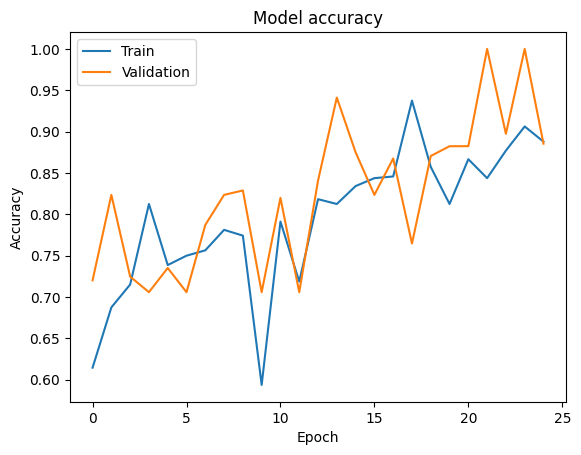

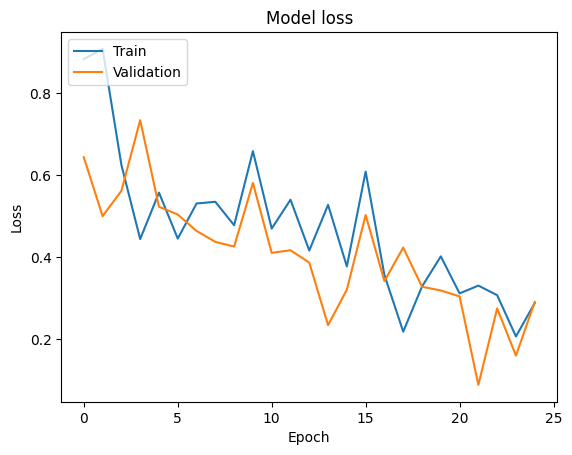

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Found 698 images belonging to 3 classes.
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 322ms/step
Test Accuracy: 86.68%


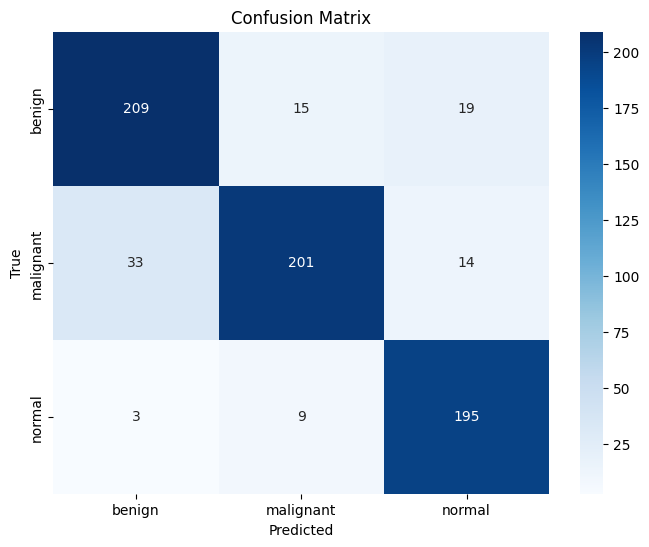

              precision    recall  f1-score   support

      benign       0.85      0.86      0.86       243
   malignant       0.89      0.81      0.85       248
      normal       0.86      0.94      0.90       207

    accuracy                           0.87       698
   macro avg       0.87      0.87      0.87       698
weighted avg       0.87      0.87      0.87       698



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Predict the labels of the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=cm_labels))


In [ ]:
##LeNet-5 pretrained model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Image size for LeNet-5
img_width, img_height = 32, 32

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values between 0 and 1
    rotation_range=10,             # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,         # Randomly shift images horizontally
    height_shift_range=0.1,        # Randomly shift images vertically
    shear_range=0.1,               # Shear transformation
    zoom_range=0.1,                # Zoom in/out by 10%
    horizontal_flip=True,          # Randomly flip images horizontally
    validation_split=0.2)          # Split data into training and validation sets

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

# Train set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Training data

# Validation set
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Validation data

# Test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 2097 images belonging to 3 classes.
Found 522 images belonging to 3 classes.
Found 698 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Defining LeNet-5 model
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(img_width, img_height, 1)),
    AveragePooling2D(pool_size=(2, 2)),  # Add pool_size argument
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),  # Add pool_size argument
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes: malignant, benign, normal
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.4804 - loss: 1.0172 - val_accuracy: 0.7720 - val_loss: 0.7571
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.6712 - loss: 0.7476 - val_accuracy: 0.7931 - val_loss: 0.5280
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.7175 - loss: 0.6425 - val_accuracy: 0.8199 - val_loss: 0.4467
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.7019 - loss: 0.6017 - val_accuracy: 0.8218 - val_loss: 0.4602
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.7180 - loss: 0.6136 - val_accuracy: 0.7950 - val_loss: 0.4501
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.7448 - loss: 0.5536 - val_accuracy: 0.8238 - val_loss: 0.4247
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.7295 - loss: 0.5723 - val_accuracy: 0.8161 - val_loss: 0.4220
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.7194 - loss: 0.5787 - val_accuracy: 0.844

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step
Test Accuracy: 78.08%


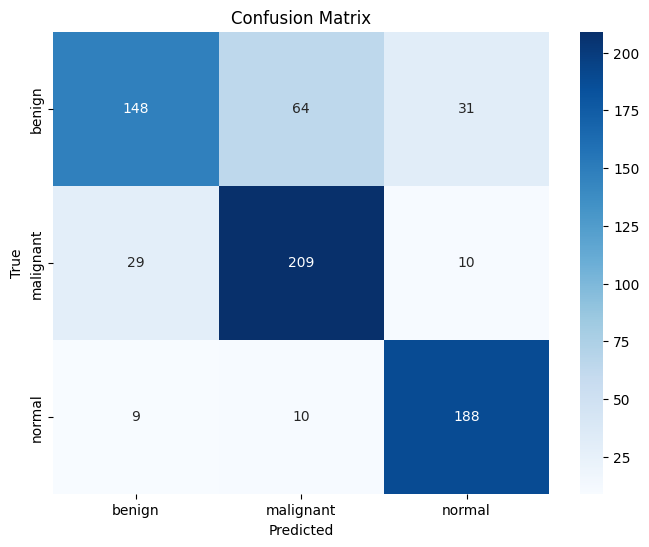

              precision    recall  f1-score   support

      benign       0.80      0.61      0.69       243
   malignant       0.74      0.84      0.79       248
      normal       0.82      0.91      0.86       207

    accuracy                           0.78       698
   macro avg       0.79      0.79      0.78       698
weighted avg       0.78      0.78      0.78       698



In [ ]:
# Predict the labels of the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=cm_labels))


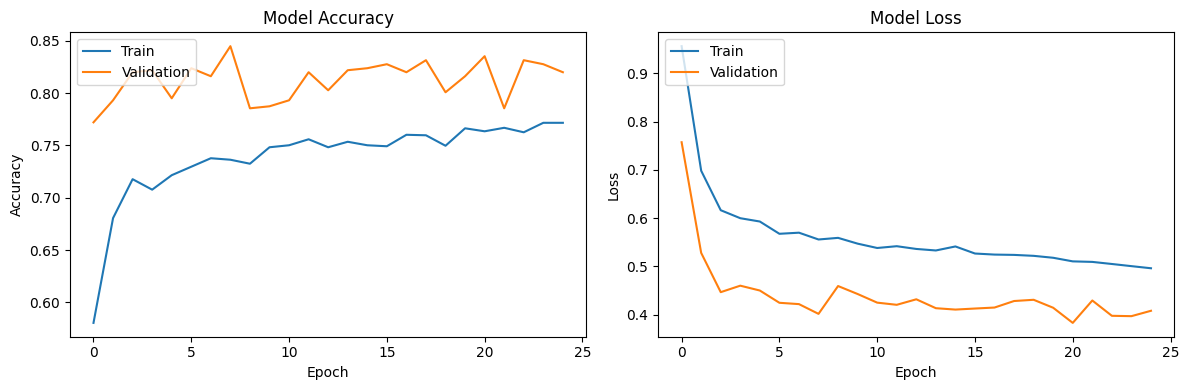

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
#Alex Net Pre-trained model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size for AlexNet
img_width, img_height = 227, 227

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values between 0 and 1
    rotation_range=20,             # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,         # Randomly shift images horizontally
    height_shift_range=0.2,        # Randomly shift images vertically
    shear_range=0.2,               # Shear transformation
    zoom_range=0.2,                # Zoom in/out by 20%
    horizontal_flip=True,          # Randomly flip images horizontally
    validation_split=0.2)          # Split data into training and validation sets

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for test data

# Train set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Training data

# Validation set
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Validation data

# Test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 2097 images belonging to 3 classes.
Found 522 images belonging to 3 classes.
Found 698 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define AlexNet model
model = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: malignant, benign, normal
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 690ms/step - accuracy: 0.4575 - loss: 1.9019 - val_accuracy: 0.7452 - val_loss: 0.5548
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - accuracy: 0.6323 - loss: 0.6770 - val_accuracy: 0.7452 - val_loss: 0.4541
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 549ms/step - accuracy: 0.6552 - loss: 0.6287 - val_accuracy: 0.7854 - val_loss: 0.4751
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 541ms/step - accuracy: 0.6697 - loss: 0.6089 - val_accuracy: 0.7950 - val_loss: 0.4520
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 566ms/step - accuracy: 0.6754 - loss: 0.6260 - val_accuracy: 0.7510 - val_loss: 0.4529
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 541ms/step - accuracy: 0.6733 - loss: 0.6365 - val_accuracy: 0.7625 - val_loss: 0.4931
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 545ms/step - accuracy: 0.6752 - loss: 0.6177 - val_accuracy: 0.8103 - val_loss: 0.4366
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 544ms/step - accuracy: 0.7447 - loss: 0.5340 - val_accuracy: 0.829

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step
Test Accuracy: 75.64%


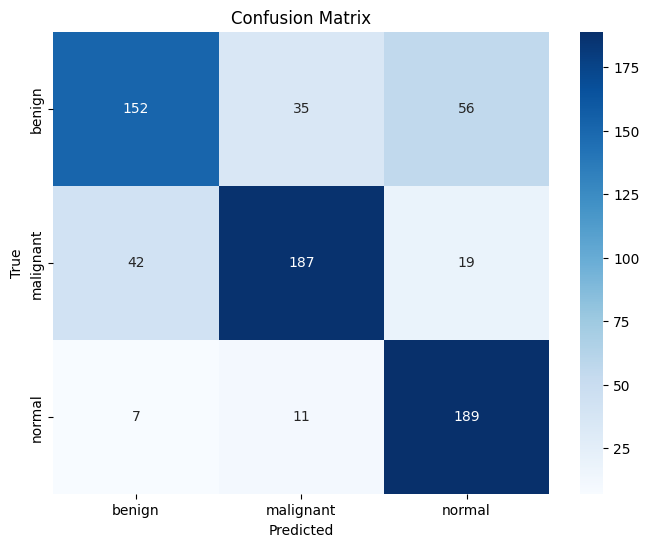

              precision    recall  f1-score   support

      benign       0.76      0.63      0.68       243
   malignant       0.80      0.75      0.78       248
      normal       0.72      0.91      0.80       207

    accuracy                           0.76       698
   macro avg       0.76      0.76      0.75       698
weighted avg       0.76      0.76      0.75       698



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the labels of the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=cm_labels))


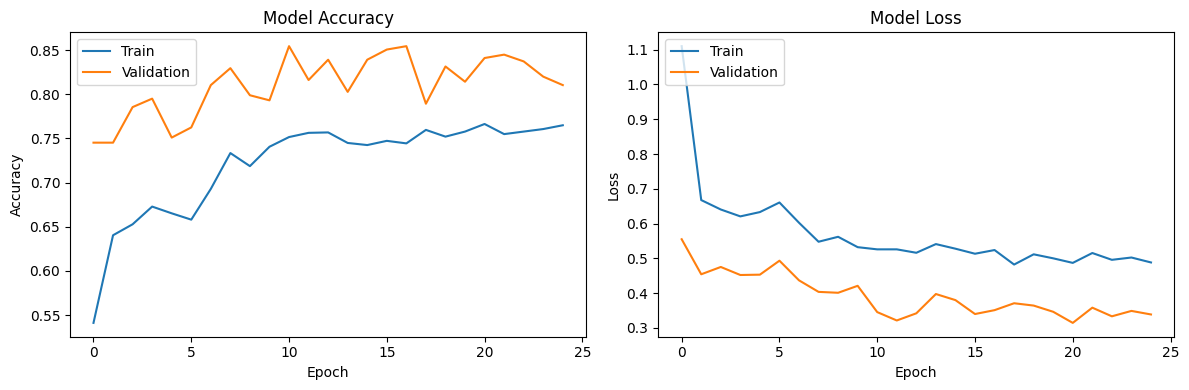

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
###VGG16 pre-trained model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image size for VGG16
img_width, img_height = 224, 224

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16 specific preprocessing
    rotation_range=20,              # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,          # Randomly shift images horizontally
    height_shift_range=0.2,         # Randomly shift images vertically
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Zoom in/out by 20%
    horizontal_flip=True,           # Randomly flip images horizontally
    validation_split=0.2)           # Split data into training and validation sets

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Only rescaling for test data

# Train set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Training data

# Validation set
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Validation data

# Test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 2097 images belonging to 3 classes.
Found 522 images belonging to 3 classes.
Found 698 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load pre-trained VGG16 model + higher level layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom layers on top of VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: malignant, benign, normal
])

# Freeze the layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 819ms/step - accuracy: 0.6614 - loss: 10.2887 - val_accuracy: 0.8755 - val_loss: 0.6270
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 605ms/step - accuracy: 0.7720 - loss: 0.6065 - val_accuracy: 0.8602 - val_loss: 0.3542
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 561ms/step - accuracy: 0.7789 - loss: 0.5285 - val_accuracy: 0.8697 - val_loss: 0.3855
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 595ms/step - accuracy: 0.7839 - loss: 0.5325 - val_accuracy: 0.8774 - val_loss: 0.3893
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 571ms/step - accuracy: 0.7850 - loss: 0.5377 - val_accuracy: 0.8621 - val_loss: 0.3737
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 560ms/step - accuracy: 0.7799 - loss: 0.5410 - val_accuracy: 0.8985 - val_loss: 0.3131
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 559ms/step - accuracy: 0.8065 - loss: 0.4935 - val_accuracy: 0.8908 - val_loss: 0.2990
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 629ms/step - accuracy: 0.8004 - loss: 0.4969 - val_accuracy: 0.87

22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 645ms/step
Test Accuracy: 91.55%


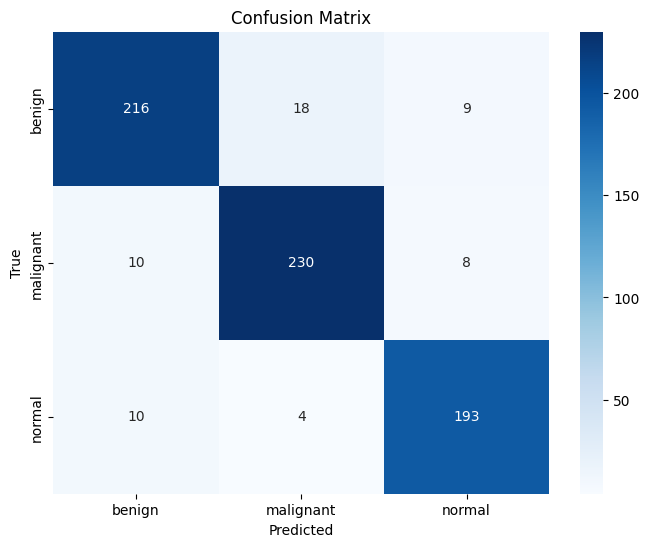

              precision    recall  f1-score   support

      benign       0.92      0.89      0.90       243
   malignant       0.91      0.93      0.92       248
      normal       0.92      0.93      0.93       207

    accuracy                           0.92       698
   macro avg       0.92      0.92      0.92       698
weighted avg       0.92      0.92      0.92       698



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the labels of the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=cm_labels))


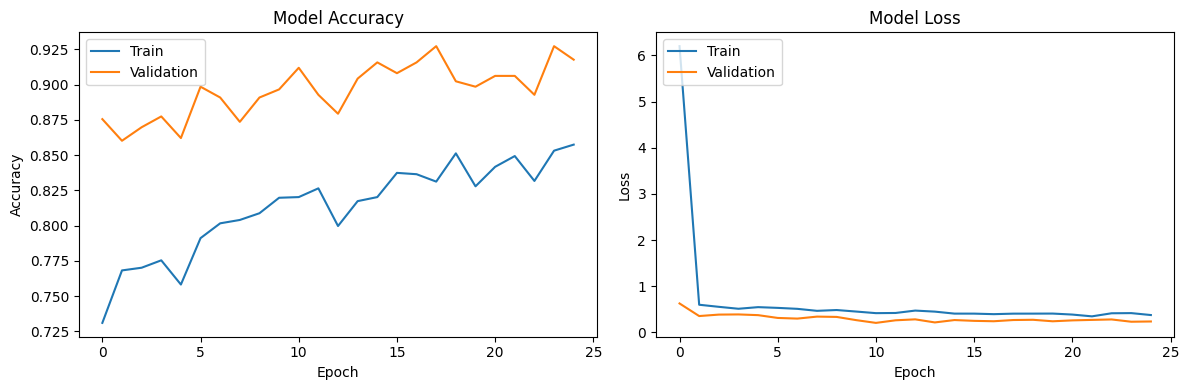

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
###ResNet50

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Image size for ResNet50
img_width, img_height = 224, 224

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 specific preprocessing
    rotation_range=20,              # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,          # Randomly shift images horizontally
    height_shift_range=0.2,         # Randomly shift images vertically
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Zoom in/out by 20%
    horizontal_flip=True,           # Randomly flip images horizontally
    validation_split=0.2)           # Split data into training and validation sets

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Only rescaling for test data

# Train set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Training data

# Validation set
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Validation data

# Test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 2097 images belonging to 3 classes.
Found 522 images belonging to 3 classes.
Found 698 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom layers on top of ResNet50
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: malignant, benign, normal
])

# Freeze the layers of the ResNet50 base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 732ms/step - accuracy: 0.6937 - loss: 15.1334 - val_accuracy: 0.8736 - val_loss: 1.0806
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 540ms/step - accuracy: 0.7791 - loss: 1.6060 - val_accuracy: 0.8352 - val_loss: 0.8516
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 535ms/step - accuracy: 0.7721 - loss: 1.0968 - val_accuracy: 0.8621 - val_loss: 0.7118
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 537ms/step - accuracy: 0.7448 - loss: 0.8984 - val_accuracy: 0.9100 - val_loss: 0.3990
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 615ms/step - accuracy: 0.7807 - loss: 0.5588 - val_accuracy: 0.9061 - val_loss: 0.2829
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 560ms/step - accuracy: 0.8151 - loss: 0.5042 - val_accuracy: 0.8908 - val_loss: 0.3777
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 553ms/step - accuracy: 0.7870 - loss: 0.4606 - val_accuracy: 0.9004 - val_loss: 0.2701
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 578ms/step - accuracy: 0.7858 - loss: 0.4653 - val_accuracy: 0.87

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step
Test Accuracy: 91.69%


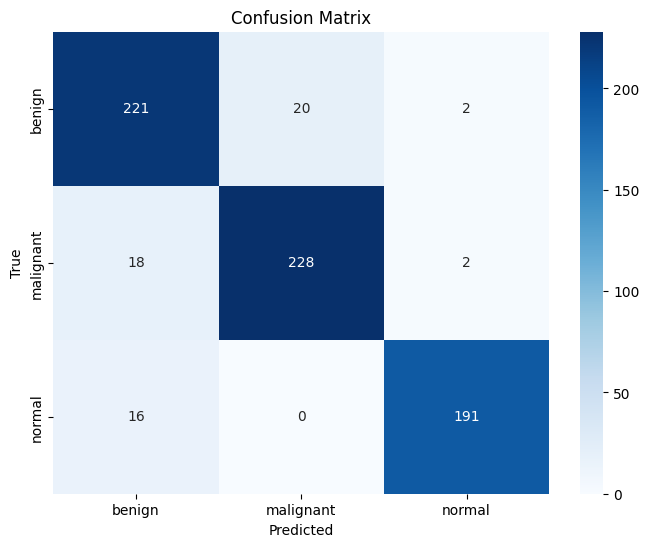

              precision    recall  f1-score   support

      benign       0.87      0.91      0.89       243
   malignant       0.92      0.92      0.92       248
      normal       0.98      0.92      0.95       207

    accuracy                           0.92       698
   macro avg       0.92      0.92      0.92       698
weighted avg       0.92      0.92      0.92       698



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the labels of the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=cm_labels))


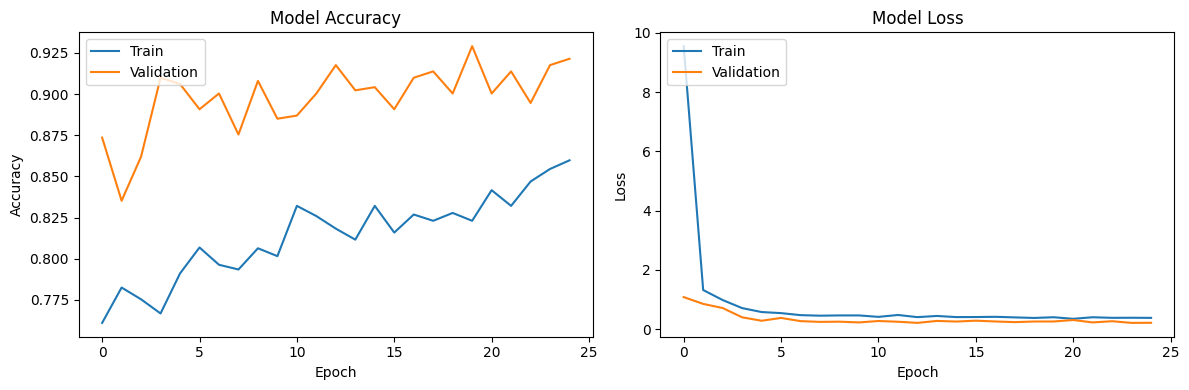

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
##GoogLeNet Pre-trained model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Image size for GoogLeNet (InceptionV3)
img_width, img_height = 299, 299

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # GoogLeNet specific preprocessing
    rotation_range=20,              # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,          # Randomly shift images horizontally
    height_shift_range=0.2,         # Randomly shift images vertically
    shear_range=0.2,                # Shear transformation
    zoom_range=0.2,                 # Zoom in/out by 20%
    horizontal_flip=True,           # Randomly flip images horizontally
    validation_split=0.2)           # Split data into training and validation sets

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Only rescaling for test data

# Train set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Training data

# Validation set
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Validation data

# Test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 2097 images belonging to 3 classes.
Found 522 images belonging to 3 classes.
Found 698 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load pre-trained GoogLeNet (InceptionV3) model + higher level layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add custom layers on top of GoogLeNet (InceptionV3)
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: malignant, benign, normal
])

# Freeze the layers of the GoogLeNet base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6581 - loss: 20.7901 - val_accuracy: 0.8678 - val_loss: 0.5917
Epoch 2/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 861ms/step - accuracy: 0.7333 - loss: 0.8029 - val_accuracy: 0.8544 - val_loss: 0.4971
Epoch 3/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 882ms/step - accuracy: 0.7289 - loss: 0.6418 - val_accuracy: 0.8659 - val_loss: 0.3334
Epoch 4/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 907ms/step - accuracy: 0.7008 - loss: 0.6426 - val_accuracy: 0.8697 - val_loss: 0.3625
Epoch 5/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 888ms/step - accuracy: 0.6749 - loss: 0.6212 - val_accuracy: 0.8525 - val_loss: 0.3758
Epoch 6/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 902ms/step - accuracy: 0.6849 - loss: 0.6297 - val_accuracy: 0.8563 - val_loss: 0.3745
Epoch 7/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 880ms/step - accuracy: 0.6999 - loss: 0.5853 - val_accuracy: 0.8966 - val_loss: 0.2777
Epoch 8/25
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 908ms/step - accuracy: 0.7054 - loss: 0.5855 - val_accuracy: 0.8966

22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 710ms/step
Test Accuracy: 85.53%


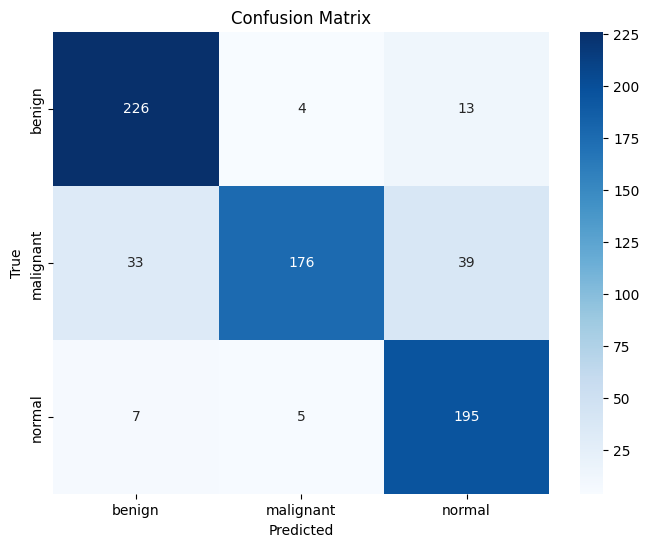

              precision    recall  f1-score   support

      benign       0.85      0.93      0.89       243
   malignant       0.95      0.71      0.81       248
      normal       0.79      0.94      0.86       207

    accuracy                           0.86       698
   macro avg       0.86      0.86      0.85       698
weighted avg       0.87      0.86      0.85       698



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict the labels of the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_labels = list(test_generator.class_indices.keys())

# Print Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=cm_labels))


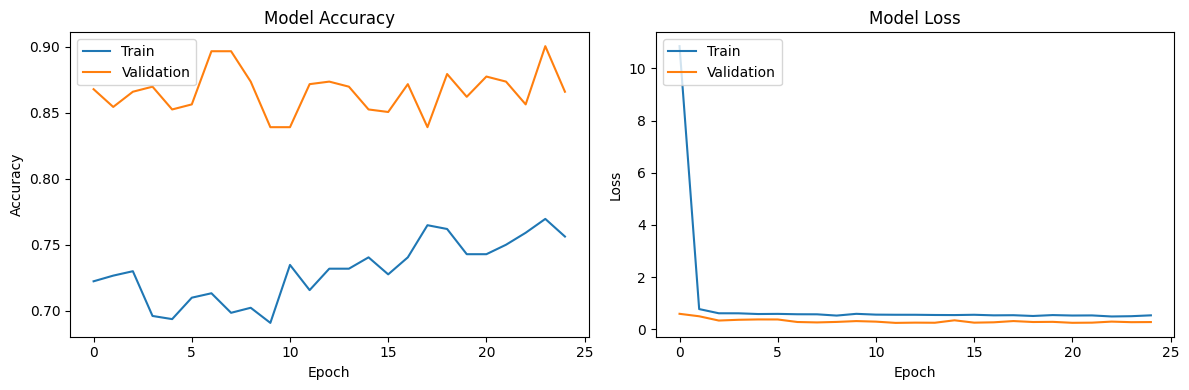

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
